# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [335]:
# initial imports
import os
import plotly.express as px
import panel as pn
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

In [336]:
# Set up Panel Plotly extension
pn.extension('plotly')

In [337]:
# Import hvplot.pandas after pn.extension
# This avoids plotly initialization failure
import hvplot.pandas

In [338]:
# Read the Mapbox API key
load_dotenv(dotenv_path="C:/Users/brett/Desktop/FTBC/.env")
map_box_api = os.getenv("MAPBOX_API_KEY")

#set mapbox API
px.set_mapbox_access_token(map_box_api)

# Import Data

In [339]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

sfo_housing_unit_grp = sfo_data.groupby(['year'])['housing_units'].mean().reset_index()

avg_gross_rent = (sfo_data.groupby(['year'])['sale_price_sqr_foot', 'gross_rent'].mean()
                  .round(2)
                  .reset_index()
                 )

avg_neighborhood_prices = (sfo_data.groupby(['year', 'neighborhood']).mean()
                           .round(2)
                           .reset_index()
                          )

avg_price_by_neighborhood = (sfo_data.groupby(['neighborhood']).mean()
                             .round(2)
                             .reset_index())

ten_most_expensive_neighborhoods = avg_price_by_neighborhood.nlargest(10, 'sale_price_sqr_foot')

neighborhood_location_values = (pd.concat([df_neighborhood_locations, avg_price_by_neighborhood],
                                axis="columns", join="inner")
                                .drop(columns='neighborhood')
                               )

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [349]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_unit_plot = plt.figure()
    plt.bar(sfo_housing_unit_grp['year'], sfo_housing_unit_grp['housing_units'])
    plt.xticks(sfo_housing_unit_grp['year'])
    plt.xlabel("Year")
    plt.ylabel("Housing Units")
    plt.title("Housing Units in San Francisco from 2010 to 2016")
    plt.tight_layout()
    plt.ylim(bottom=360000, top=390000)
    plt.close(housing_unit_plot)
    
    return housing_unit_plot

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    avg_gross_rent_plot = plt.figure()
    plt.plot(avg_gross_rent['year'], avg_gross_rent['gross_rent'], marker='o', markersize=7)
    plt.title("Average Gross Rent in San Francisco")
    plt.xlabel("Year")
    plt.ylabel("Gross Rent")
    plt.grid(True)
    plt.close(avg_gross_rent_plot)
    
    return avg_gross_rent_plot

def average_sales_price():
    """Average Sales Price Per Year."""
    avg_price_sqft_plot = plt.figure()
    plt.plot(avg_gross_rent['year'], avg_gross_rent['sale_price_sqr_foot'], marker='o', markersize=7)
    plt.title("Average Sales Price per Square Foot in San Francisco")
    plt.xlabel("Year")
    plt.ylabel("Avg Sales Price per SqFt")
    plt.grid(True)
    plt.close(avg_price_sqft_plot)
    
    return avg_price_sqft_plot

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    avg_neighborhood_price_plot = avg_neighborhood_prices.hvplot.line(
        x='year', y="sale_price_sqr_foot",
        xlabel='Year', ylabel='Avg. Sales Price per SqFt',
        groupby='neighborhood',
        height=400
    )
    return avg_neighborhood_price_plot

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    ten_most_expensive_neighborhoods_plot = ten_most_expensive_neighborhoods.hvplot.bar(
        x='neighborhood', y='sale_price_sqr_foot', rot=45,
        ylabel='Avg. Sales Price per SqFt', xlabel='Neighborhood',
        title='Top 10 Expensive Neighborhoods in San Francisco',
        height=475
    )
    return ten_most_expensive_neighborhoods_plot

def parallel_coordinates():
    """Parallel Coordinates Plot."""  
    parallel_coordinates_plot = px.parallel_coordinates(
        ten_most_expensive_neighborhoods,
        color='sale_price_sqr_foot',
        color_continuous_scale=px.colors.sequential.Inferno,
        title="Parallel Coordinates Plot of the Top 10 Most Expensive Neighborhoods",
        width=1000,
        labels={"sale_price_sqr_foot":"Sale Price per SqFt",
                "housing_units":"Housing Units",
                "gross_rent":"Gross Rent"}
    )
    return parallel_coordinates_plot

def parallel_categories():
    """Parallel Categories Plot."""
    parallel_categories_plot = px.parallel_categories(
        ten_most_expensive_neighborhoods,
        dimensions=['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent'],
        color='sale_price_sqr_foot',
        color_continuous_scale=px.colors.sequential.Inferno,
        title="Parallel Categories Plot of the Top 10 Most Expensive Neighborhoods",
        width=1000,
        labels={"neighborhood":"Neighborhood",
                "sale_price_sqr_foot":"Sale Price per SqFt",
                "housing_units":"Housing Units",
                "gross_rent":"Gross Rent"}
    )
    return parallel_categories_plot

def neighborhood_map():
    """Neighborhood Map"""
    neighborhood_map_plot = px.scatter_mapbox(
        neighborhood_location_values,
        lat='Lat',lon='Lon',
        size='sale_price_sqr_foot',
        hover_name='Neighborhood',
        color='gross_rent',
        color_continuous_scale=px.colors.cyclical.Phase,
        title='Average Sales Price Per Square Foot and Gross Rent in San Francisco',
        zoom=10.75, mapbox_style='outdoors')
    
    return neighborhood_map_plot

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [350]:
# YOUR CODE HERE!
home_page = pn.Column('''Welcome, this dashboard shows housing data analysis for San Francisco from 2010 to 2016.
                    By switching between the tabs you can view yearly market analysis, neighborhood analysis, and parallel plot analysis.''',
                    neighborhood_map(),
                    top_most_expensive_neighborhoods()
                     )

yearly_analysis_row = pn.Row(housing_units_per_year(),
                             average_gross_rent(),
                             average_sales_price(),
                            )

neighborhood_analysis_column = pn.Row(average_price_by_neighborhood())

parallel_plots = pn.Column(parallel_coordinates(), 
                          parallel_categories()
                          )

sfo_housing_dashboard = pn.Tabs(
    ("Home Page", home_page),
    ("Yearly Analysis", yearly_analysis_row),
    ("Neighborhood Analysis", neighborhood_analysis_column),
    ("Parallel Plots Analysis", parallel_plots)
)

## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] HoloViews(Bars)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Row
        [0] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
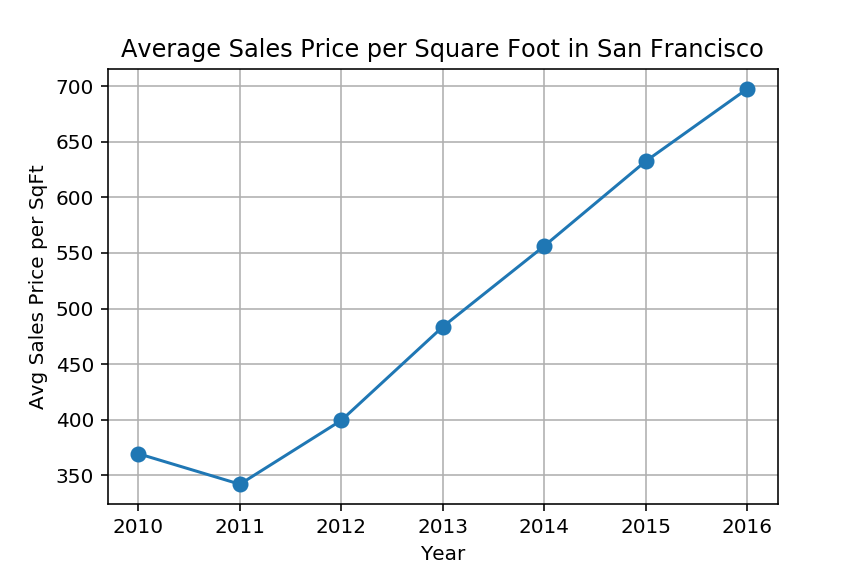
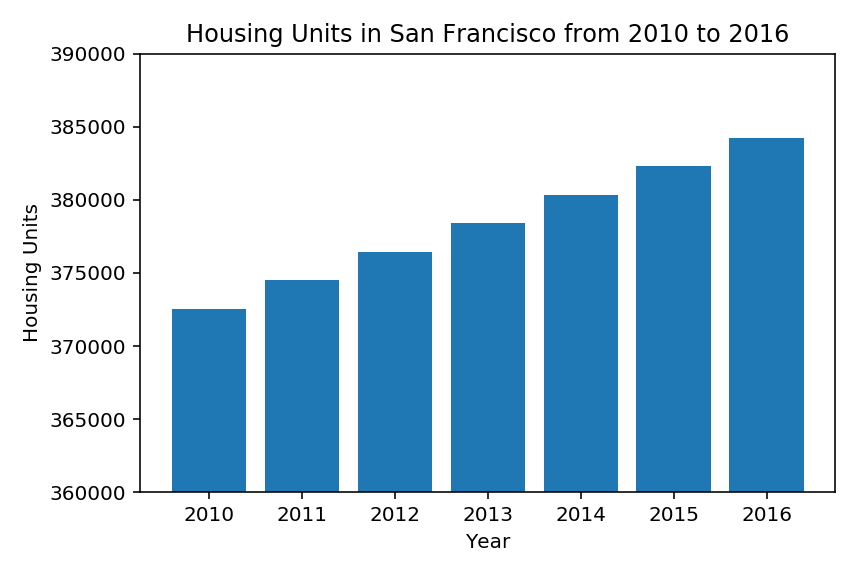
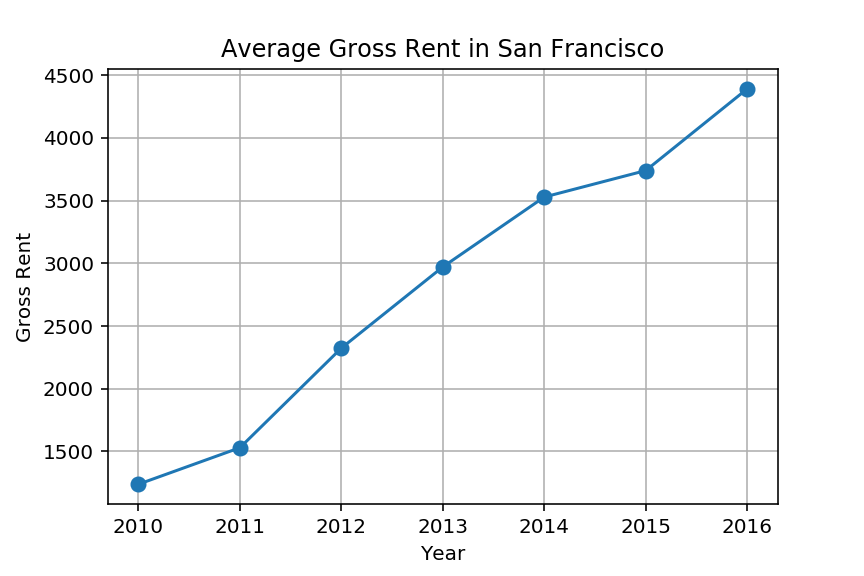

In [351]:
# panel.servable()
sfo_housing_dashboard.servable()